In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

# Generate synthetic dataset
np.random.seed(42)
X1, _ = make_blobs(n_samples=150, centers=[[-2, 2]], cluster_std=0.3)  # Dense cluster
X2, _ = make_blobs(n_samples=150, centers=[[2, -2]], cluster_std=1.0)  # Sparse cluster
X_outliers = np.random.uniform(low=-5, high=5, size=(50, 2))  # Outliers
X = np.vstack([X1, X2, X_outliers])

# DBSCAN parameters
eps = 0.6  # Neighborhood radius
min_samples = 5  # Minimum points to be a core point

In [2]:
nbrs = NearestNeighbors(radius=eps).fit(X)
neighbors = nbrs.radius_neighbors(X, return_distance=False)

core_mask = np.array([len(neigh) >= min_samples for neigh in neighbors])

labels = np.full(len(X), -1)  # -1 means noise
cluster_id = 0

for i in range(len(X)):
    if labels[i] != -1 or not core_mask[i]:
        continue
    labels[i] = cluster_id
    queue = list(neighbors[i])
    while queue:
        point = queue.pop(0)
        if labels[point] == -1:
            labels[point] = cluster_id
        if core_mask[point]:
            for neighbor in neighbors[point]:
                if labels[neighbor] == -1:
                    labels[neighbor] = cluster_id
                    queue.append(neighbor)
    cluster_id += 1

border_mask = (labels != -1) & (~core_mask)

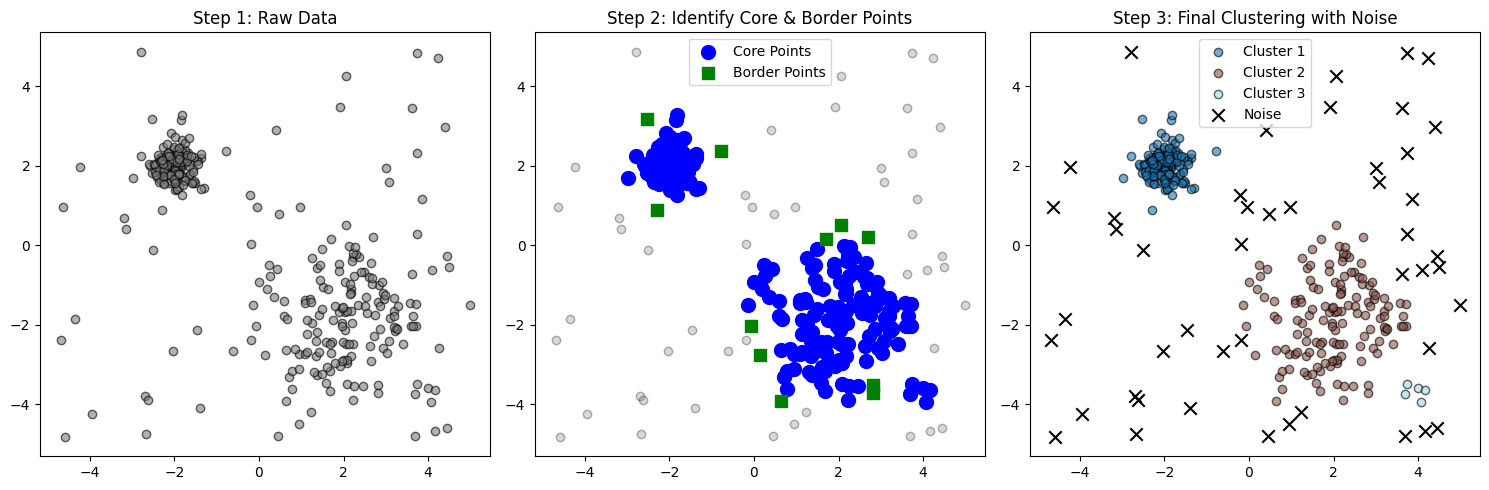

DBSCAN completed. Found 3 clusters and 47 noise points.


In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(X[:, 0], X[:, 1], c="gray", edgecolors='k', alpha=0.6)
axes[0].set_title("Step 1: Raw Data")

axes[1].scatter(X[:, 0], X[:, 1], c="gray", edgecolors='k', alpha=0.3)
axes[1].scatter(X[core_mask, 0], X[core_mask, 1], c="blue", s=100, label='Core Points')
axes[1].scatter(X[border_mask, 0], X[border_mask, 1], c="green", s=80, marker='s', label='Border Points')
axes[1].set_title("Step 2: Identify Core & Border Points")
axes[1].legend()

unique_labels = np.unique(labels[labels != -1])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
for i, label in enumerate(unique_labels):
    mask = labels == label
    axes[2].scatter(X[mask, 0], X[mask, 1], color=colors[i], edgecolors='k', 
                    alpha=0.6, label=f"Cluster {i+1}")

noise_mask = labels == -1
if np.any(noise_mask):
    axes[2].scatter(X[noise_mask, 0], X[noise_mask, 1], c="black", marker='x', 
                    s=80, label="Noise")
axes[2].set_title("Step 3: Final Clustering with Noise")
axes[2].legend()
plt.tight_layout()
plt.savefig("./figures/dbscan.jpg")
plt.show()
print(f"DBSCAN completed. Found {len(unique_labels)} clusters and {np.sum(noise_mask)} noise points.")